In [1]:
# RUN THIS COMMAND ONLY IF YOU USE GOOGLE COLAB.
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# RUN THIS COMMAND ONLY IF YOU USE GOOGLE COLAB.
#%cd drive/MyDrive/commfy

# Multiclass Classifier to Predict Feet Items 
The objective of this notebook is to build a machine learning model that predicts feet items (shoe & sock combination) by leveraging k-nearest neighbors and random forest classifiers.

## 1. Importing required modules and loading data file
In the first section of this notebook, we have to import all neccessary libraries, required modules and essential packages. After running them in this cell, we will be able to use them in subsequent cells throughout the notebook.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for displaying plots
import seaborn as sns; sns.set(style='ticks') # plotting package for histograms
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from matplotlib import cm #for creating color maps
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report

In [4]:
#skipping some rows and reading only relevant parts into dataframe
feets = pd.read_csv('input_data.csv', skiprows=2) 
#starting index from 1 in a dataframe
feets.index = feets.index + 1

<hr style="border:2px solid gray"> </hr>

## 2. Exploratory data analysis (EDA) and data cleaning
In this section, it is essential to conduct the initial investigations on data to discover the patterns, identify outliers and spot noises with the help of summary statistics and graphical representations. The goal of EDA is to summarize the important characteristics of data in order to gain better understanding of the dataset and prepare data for machine learning.

### The first step in EDA is to pre-process the dataset
After importing the dataset and having a quick glance at a data, we transformed raw data to well-formed dataset.

In [5]:
#viewing the dataset & checking if data has been read into a dataframe object
feets.head(10)

Unnamed: 0          a    b       c    d    e   f
1            0  23.633087  1.0  cloudy  1.0  1.0  -2
2            1  38.742237  1.0   sunny  0.0  1.0   0
3            2        NaN  1.0   sunny  1.0  2.0   2
4            3  22.249957  1.0   sunny  0.0  1.0  -5
5            4  27.007875  1.0  cloudy  0.0  0.0  -2
6            5  37.733175  1.0   sunny  1.0  1.0   0
7            6  23.452793  1.0   sunny  2.0  NaN   3
8            7  29.576284  1.0  cloudy  0.0  0.0   2
9            8  20.621831  1.0  cloudy  0.0  0.0   0
10           9  26.420650  1.0  cloudy  1.0  2.0  44

In [6]:
#renaming the columns with self-explanatory titles
feets.rename({"a": "temperature", "b": "feet_class", "c": "weather","d": "sex", "e":"heaviness_trip", "f":"heat_perception"},axis = 1, inplace = True)

In [7]:
#slicing out the unneccesary column
feets = feets.iloc[: , 1:]

In [8]:
#checking how many values are missing for each column
feets.isnull().sum(axis=0)

temperature        4
feet_class         2
weather            2
sex                1
heaviness_trip     4
heat_perception    0
dtype: int64

Due to low amount of missing values, it was decided to drop them.

In [9]:
#dropping rows with NaN values
feets.dropna(inplace = True)

In [10]:
#finding out the columns & their corresponding data types
feets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24988 entries, 1 to 25000
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      24988 non-null  float64
 1   feet_class       24988 non-null  float64
 2   weather          24988 non-null  object 
 3   sex              24988 non-null  float64
 4   heaviness_trip   24988 non-null  float64
 5   heat_perception  24988 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.3+ MB


In [11]:
#converting feet_class, sex and heaviness_trip from float to int
feets = feets.astype({"feet_class":'int', "sex":'int', "heaviness_trip": 'int'}) 
display(feets.dtypes)

temperature        float64
feet_class           int32
weather             object
sex                  int32
heaviness_trip       int32
heat_perception      int64
dtype: object

In [12]:
#getting unique values of heat_perception series object
feets['heat_perception'].unique()

array([-2,  0, -5,  2, 44,  4, -4,  5, -3, -1,  3,  1], dtype=int64)

In [13]:
#replacing the incorrect value the correct one
feets['heat_perception'].replace([44],[4], inplace=True)

In [14]:
#checking if the replacement have been placed
feets['heat_perception'].unique()

array([-2,  0, -5,  2,  4, -4,  5, -3, -1,  3,  1], dtype=int64)

In [15]:
feets['weather'].unique()

array(['cloudy', 'sunny', 'sunnny', 'cloudi', 'Sunny', 'snowy', 'rainy',
       'rayny', 'raiiny'], dtype=object)

In [16]:
#harmonising values in weather state column with df.replace()
feets.replace(['cloudi', 'sunnny','Sunny', 'rayny','raiiny'], ['cloudy', 'sunny', 'sunny', 'rainy','rainy'],inplace=True)
feets['weather'].replace(['cloudy','sunny','snowy','rainy'],[4,1,3,2],inplace=True)

In [17]:
#checking if the changes have been placed
feets['weather'].unique()

array([4, 1, 3, 2], dtype=int64)

### The second step is to conduct descriptive statistics of a datatset.
We call the describe() function to gain insights into the shape of each attribute by creating summary statistics by viewing central tendency, mean, median, standard deviation, percentile and max values.

In [18]:
round(feets.describe(), 2) #for the statistical summary of numerical data

temperature  feet_class   weather       sex  heaviness_trip  \
count     24988.00    24988.00  24988.00  24988.00        24988.00   
mean          9.21        3.00      2.33      0.53            1.00   
std          15.72        1.41      1.14      0.54            0.82   
min         -17.19        1.00      1.00      0.00            0.00   
25%          -5.51        2.00      1.00      0.00            0.00   
50%           5.54        3.00      2.00      1.00            1.00   
75%          24.47        4.00      4.00      1.00            2.00   
max          55.27        5.00      4.00      2.00            2.00   

       heat_perception  
count         24988.00  
mean              0.02  
std               3.17  
min              -5.00  
25%              -3.00  
50%               0.00  
75%               3.00  
max               5.00

### The third step is to create bar charts.
The bar charts on categorical variables show the class distribution of the independent variables (x axis distinct items, y axis frequency).

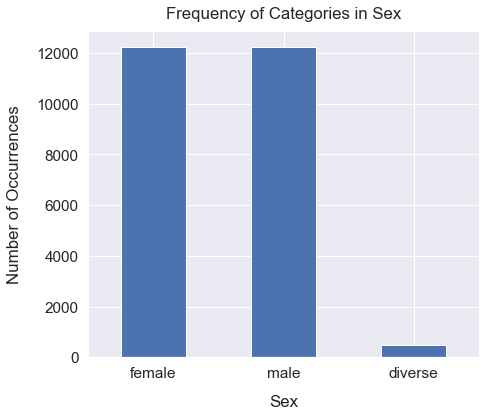

In [19]:
#creating a bar chart on the frequency of categories in the 'sex' variable
sns.set(font_scale=1.4)
feets['sex'].replace([0, 1, 2],['male','female','diverse']).value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Sex", labelpad=14)
plt.ylabel("Number of Occurrences", labelpad=14)
plt.title("Frequency of Categories in Sex", y=1.02);

There are equal frequencies for female and male categories. The occurences of diverse category in this dataset corresponds to the relatively less number of diverse people (intersex?) in general.

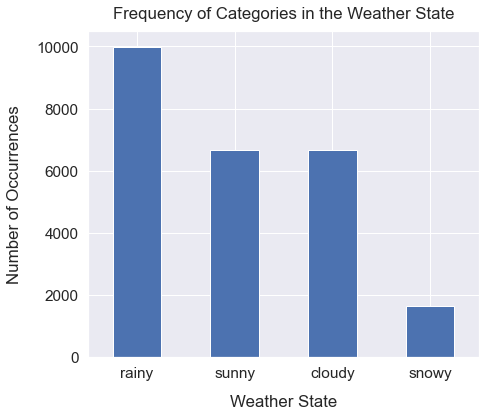

In [20]:
#creating a bar chart on the frequency of categories in the 'weather' variable
sns.set(font_scale=1.4)
feets['weather'].replace([4,1,3,2],['cloudy','sunny','snowy','rainy']).value_counts().plot(kind='bar', figsize=(7,6), rot=0)
plt.xlabel("Weather State", labelpad=14)
plt.ylabel("Number of Occurrences", labelpad=14)
plt.title("Frequency of Categories in the Weather State", y=1.02);

The frequency of cloudy category in the variable weather is minimal which is also displayed in the bart chart. The dataset contains high frequency of sunny weather state and approximately twice as less of rainy observations.

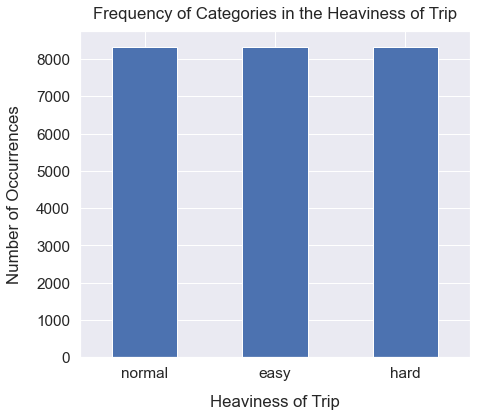

In [21]:
##creating a bar chart on the frequency of categories in the 'heaviness_trip' variable
sns.set(font_scale=1.4)
feets["heaviness_trip"].replace([0, 1, 2],['easy','normal','hard']).value_counts().plot(kind='bar', figsize=(7,6), rot=0)
plt.xlabel("Heaviness of Trip", labelpad=14)
plt.ylabel("Number of Occurrences", labelpad=14)
plt.title("Frequency of Categories in the Heaviness of Trip", y=1.02);

There are almost equal occurrences of all three categories in the weather state.

### This forth step is to plot histograms/kernel density plots for each variables. 
This visualization technique will enable us to see how frequently data in each class occur in the dataset. Namely, it will graphically show the frequency of different data points in the dataset, location of the center of data, the spread of dataset, skewness of dataset and presence of outliers.

Text(0.5, 1.0, 'Histogram of Temperature')

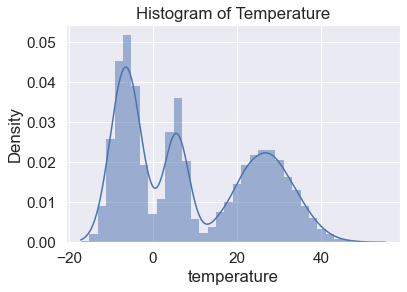

In [22]:
sns.histplot(feets["temperature"], kde = True, stat="density", linewidth=0).set_title("Histogram of Temperature")

Interpretations of histogram:
The distribution deviates strongly from a normal one and has multiple peaks (multimodal). The data contains many observations both in the colder and warmer season. On the contrary, there is a surprising low amount of 10-15 Degree Celsius observations. 

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Low shoes + socks'),
  Text(1, 0, 'boots + socks'),
  Text(2, 0, 'boots + wool socks'),
  Text(3, 0, 'rainproof shoes + socks'),
  Text(4, 0, 'rainproof shoes + wool socks')])

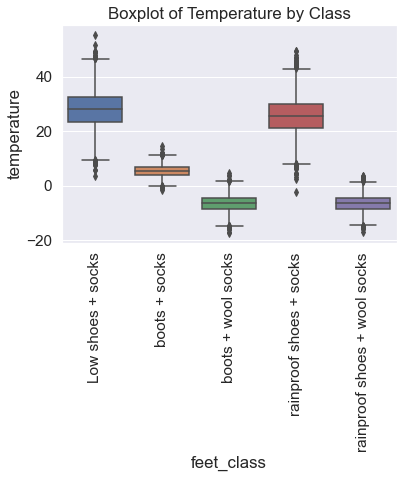

In [23]:
ax = sns.boxplot(x="feet_class", y="temperature", data=feets.replace([1,2,3,4,5],["Low shoes + socks", "boots + socks", "boots + wool socks", "rainproof shoes + socks", "rainproof shoes + wool socks"])).set_title("Boxplot of Temperature by Class")
plt.xticks(rotation=90)

Interpretations of boxplots: There is a clear difference between several classes in regard to median of 
data observable, although blue & red are almost identical, as well as green and purple. When 
looking at the data it makes sense, since these are the rain and no-rain boot variants.

### The last step of this section checks the correlation between features in a dataset by calling df.corr()

 
 It calculates the correlation between features pairwise excluding null values. Thus, we will gain understanding on one or multiple attributes that might be dependent on another attribute or a cause for another attribute.Feature correlations matter in predicting one attribute from another.

The cell computes a correlation matrix (Max's note: be mindful of the type of correlation and the scale level of the variable, pearson vs. spearman correlation)

In [24]:
#computing correlation between temperature and heat perception for training purposes
column_1 = feets["temperature"]
column_2 = feets["heat_perception"]
correlation = round(column_1.corr(column_2), 2)
print(correlation)

0.08


<hr style="border:2px solid gray"> </hr>

## 4. Model training
In this chapter, we will feed the ML algorithms with data to help identify and learn good values for all attributes involved.

In [25]:
#mapping the class numbers to correspongins names to ease the ML-related work process
class_name=feets['feet_class'].replace([1,2,3,4,5],["Low shoes + socks", "boots + socks", "boots + wool socks", "rainproof shoes + socks", "rainproof shoes + wool socks"]).unique()

The following code splits machine learning data into three datatsets: train-set, validation- and test-sets. The third set is important to test the final performance of the model. It is used only  on the fine-tuned model. Once it is used, it loses its "value".

In [26]:
# assigning input data to 'X' variable and output data to 'y' variable
X = feets[['temperature', 'sex','heat_perception', 'heaviness_trip','weather']]
y = feets['feet_class']

# splitting variables into train, test, or validation sets (default is 75% training data and 25% validation data )
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30, random_state=0)
#X_train, X_validation,y_train,y_validation =train_test_split(X_train_help, y_train_help,test_size=0.25, random_state=0)

In [27]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (17491, 5)
Training Labels Shape: (17491,)
Testing Features Shape: (7497, 5)
Testing Labels Shape: (7497,)


### Defining dummy classifiers
DummyClassifier is a classifier that makes predictions using simple rules, which can be useful as a baseline for comparison against actual classifiers, especially with imbalanced classes.

In [28]:
# Negative class (0) is most frequent
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
# Therefore the dummy 'most_frequent' classifier always predicts class 0
y_dummy_predictions = dummy_majority.predict(X_test)
y_dummy_predictions

array([4, 4, 4, ..., 4, 4, 4])

In [29]:
# calculate the mean errors to have a set the lowest bar for the comming classifiers:

print('MAE:', metrics.mean_absolute_error(y_test,y_dummy_predictions))
print('MSE:', metrics.mean_squared_error(y_test, y_dummy_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_dummy_predictions)))

MAE: 1.4097639055622249
MSE: 3.018140589569161
RMSE: 1.7372796520909237


## KNN - K nearest Neighbor Classification tuned and untuned prediction

### Defining classifier objects

In [30]:
knn = KNeighborsClassifier().fit(X_train,y_train)

In [31]:
knn_prediction=knn.predict(X_test)
knn_prediction

array([1, 4, 3, ..., 3, 3, 2])

In [32]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

Most interesting hyper parameters

In [33]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,20,2))
n_neighbors = list(range(1,10))
p=[1,2]

In [34]:
params= dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

In [35]:
knn_tune=KNeighborsClassifier()

In [36]:
knn_tuning_model=GridSearchCV(knn_tune,param_grid=params,scoring='neg_mean_squared_error',cv=3,verbose=3)

In [37]:
knn_tuning_model.fit(X_train,y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV 1/3] END ..leaf_size=1, n_neighbors=1, p=1;, score=-0.103 total time=   0.2s
[CV 2/3] END ..leaf_size=1, n_neighbors=1, p=1;, score=-0.073 total time=   0.2s
[CV 3/3] END ..leaf_size=1, n_neighbors=1, p=1;, score=-0.092 total time=   0.1s
[CV 1/3] END ..leaf_size=1, n_neighbors=1, p=2;, score=-0.118 total time=   0.3s
[CV 2/3] END ..leaf_size=1, n_neighbors=1, p=2;, score=-0.081 total time=   0.1s
[CV 3/3] END ..leaf_size=1, n_neighbors=1, p=2;, score=-0.105 total time=   0.2s
[CV 1/3] END ..leaf_size=1, n_neighbors=2, p=1;, score=-0.074 total time=   0.1s
[CV 2/3] END ..leaf_size=1, n_neighbors=2, p=1;, score=-0.094 total time=   0.1s
[CV 3/3] END ..leaf_size=1, n_neighbors=2, p=1;, score=-0.086 total time=   0.2s
[CV 1/3] END ..leaf_size=1, n_neighbors=2, p=2;, score=-0.097 total time=   0.2s
[CV 2/3] END ..leaf_size=1, n_neighbors=2, p=2;, score=-0.110 total time=   0.3s
[CV 3/3] END ..leaf_size=1, n_neighbors=2, p=2

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'p': [1, 2]},
             scoring='neg_mean_squared_error', verbose=3)

In [38]:
knn_tuning_model.best_params_

{'leaf_size': 1, 'n_neighbors': 8, 'p': 1}

### Training the Knn Classifier with best performing hyperparameters

In [39]:
knn_tuned_hyper_model=KNeighborsClassifier(leaf_size= 1, n_neighbors= 8, p=1).fit(X_train,y_train)

In [40]:
knn_tuned_pred=knn_tuned_hyper_model.predict(X_test)

In [89]:
# With hyperparameter tuned 

print('MAE:', round(metrics.mean_absolute_error(y_test,knn_tuned_pred),6))
print('MSE:', round(metrics.mean_squared_error(y_test, knn_tuned_pred),6))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, knn_tuned_pred)),6))

MAE: 0.027478
MSE: 0.071762
RMSE: 0.267884


In [90]:
# without hyperparameter tuning 

print('MAE:', round(metrics.mean_absolute_error(y_test,knn_prediction),6))
print('MSE:', round(metrics.mean_squared_error(y_test, knn_prediction),6))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, knn_prediction)),6))

MAE: 0.043617
MSE: 0.113245
RMSE: 0.336519


### Tuning decreased the mean errors --> Tuning was succesfull

________________________________________________________________________
### Decision Tree: Tuning the decision tree hyperparameters

doing exactly the same as for the Knn Classifier tuning

In [43]:
dec_tree_clf_model = DecisionTreeClassifier().fit(X_train,y_train)


calculate the prediciton for the untuned Classifier to be able to compare later the mean errors with the tuned classifier

In [44]:
prediction=dec_tree_clf_model.predict(X_test)
prediction

array([1, 4, 3, ..., 3, 3, 1])

### Hyper-parameter tuning
List of possible Hyperparameters

In [45]:
dec_tree_clf_model.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [46]:
n_components = list(range(1,X.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = list(range(1,15))

In [47]:
parameters = dict(max_features=n_components,
                criterion=criterion,
                max_depth=max_depth)

In [48]:
tuning_model=GridSearchCV(dec_tree_clf_model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)

In [49]:
tuning_model.fit(X_train,y_train)

Fitting 3 folds for each of 140 candidates, totalling 420 fits
[CV 1/3] END criterion=gini, max_depth=1, max_features=1;, score=-2.093 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=1, max_features=1;, score=-2.996 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=1, max_features=1;, score=-2.540 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=1, max_features=2;, score=-2.093 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=1, max_features=2;, score=-2.969 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=1, max_features=2;, score=-2.029 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=1, max_features=3;, score=-2.093 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=1, max_features=3;, score=-2.969 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=1, max_features=3;, score=-2.791 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=1, max_features=4;, score=-2.792 total time=   0.0s
[CV 2/3] END criterion=gini

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14],
                         'max_features': [1, 2, 3, 4, 5]},
             scoring='neg_mean_squared_error', verbose=3)

In [50]:
tuning_model.best_params_

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 3}

### Training the decision dree with best performing hyperparameters

In [75]:
tuned_hyper_model=DecisionTreeClassifier(criterion= 'entropy', max_depth= 10, max_features= 4).fit(X_train,y_train)

In [76]:
tuned_pred=tuned_hyper_model.predict(X_test)

In [91]:
# With hyperparameter tuned 

print('MAE:', round(metrics.mean_absolute_error(y_test,tuned_pred),6))
print('MSE:', round(metrics.mean_squared_error(y_test, tuned_pred),6))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, tuned_pred)),6))

MAE: 0.003335
MSE: 0.003335
RMSE: 0.057747


In [92]:
# without hyperparameter tuning 

print('MAE:', round(metrics.mean_absolute_error(y_test,prediction),6))
print('MSE:', round(metrics.mean_squared_error(y_test, prediction),6))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, prediction)),6))

MAE: 0.010938
MSE: 0.021075
RMSE: 0.145173


In [55]:
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

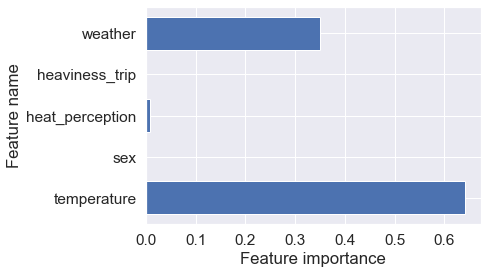

In [56]:
#creating a plot on the importance of features
plot_feature_importances(tuned_hyper_model,['temperature', 'sex','heat_perception', 'heaviness_trip','weather'] )

In [57]:
#creating s decision trees
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (30,30), dpi=450)
plot_tree(tuned_hyper_model,class_names=class_name,feature_names=['temperature', 'sex','heat_perception', 'heaviness_trip','weather'], filled=True)

[Text(6326.9482825413215, 9729.204545454546, 'temperature <= 10.643\nentropy = 2.322\nsamples = 17491\nvalue = [3494, 3477, 3508, 3537, 3475]\nclass = rainproof shoes + socks'),
 Text(2926.3655733471073, 8802.613636363636, 'temperature <= 0.656\nentropy = 1.631\nsamples = 10502\nvalue = [22, 3460, 3508, 37, 3475]\nclass = boots + wool socks'),
 Text(1037.603305785124, 7876.022727272727, 'weather <= 2.5\nentropy = 1.038\nsamples = 6971\nvalue = [0, 30, 3484, 1, 3456]\nclass = boots + wool socks'),
 Text(562.0351239669421, 6949.431818181818, 'weather <= 1.5\nentropy = 0.838\nsamples = 4609\nvalue = [0, 14, 1138, 1, 3456]\nclass = rainproof shoes + wool socks'),
 Text(345.8677685950413, 6022.840909090909, 'temperature <= -0.016\nentropy = 0.095\nsamples = 1152\nvalue = [0, 14, 1138, 0, 0]\nclass = boots + wool socks'),
 Text(172.93388429752065, 5096.25, 'temperature <= -1.391\nentropy = 0.019\nsamples = 1138\nvalue = [0, 2, 1136, 0, 0]\nclass = boots + wool socks'),
 Text(86.4669421487603

_______________________________________________________
### Random Forest Classifier

In [58]:
random_forest_clf = RandomForestClassifier().fit(X_train, y_train)

calculate the prediciton for the untuned Classifier to be able to compare later the mean errors with the tuned classifier

In [59]:
random_prediction=random_forest_clf.predict(X_test)
random_prediction

array([1, 4, 3, ..., 3, 3, 2])

### Hyper-parameter tuning
List of possible Hyperparameters

In [60]:
random_forest_clf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [61]:
rf_clf = RandomForestClassifier()

In [62]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [63]:
rf_random = RandomizedSearchCV(estimator = rf_clf,param_distributions = random_grid,
            n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [64]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=35, verbose=2)

In [65]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

### Training the decision dree with best performing hyperparameters

In [66]:
tuned_rf_model=RandomForestClassifier(n_estimators= 100,min_samples_split= 6,min_samples_leaf= 3,max_features= 'auto',max_depth= 30, bootstrap= False).fit(X_train,y_train)

In [67]:
tuned_rf_pred=tuned_rf_model.predict(X_test)

In [93]:
# With hyperparameter tuned 

print('MAE:', round(metrics.mean_absolute_error(y_test,tuned_rf_pred),6))
print('MSE:', round(metrics.mean_squared_error(y_test, tuned_rf_pred),6))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, tuned_rf_pred)),6))

MAE: 0.002001
MSE: 0.002001
RMSE: 0.04473


In [94]:
# without hyperparameter tuning 

print('MAE:', round(metrics.mean_absolute_error(y_test,random_prediction),6))
print('MSE:', round(metrics.mean_squared_error(y_test, random_prediction),6))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, random_prediction)),6))

MAE: 0.001867
MSE: 0.001867
RMSE: 0.043214


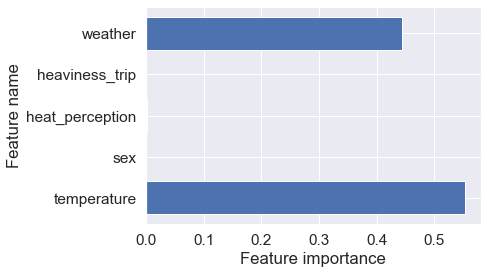

In [78]:
#creating a plot on the importance of features
plot_feature_importances(tuned_rf_model,['temperature', 'sex','heat_perception', 'heaviness_trip','weather'] )

<hr style="border:2px solid gray"> </hr>

## 5. Model Evaluation
In this chapter, we will evaluate the 3 tuned Models and the dummy classifier

we want to compare in a chart the 4 different classifier by plotting there error metrics

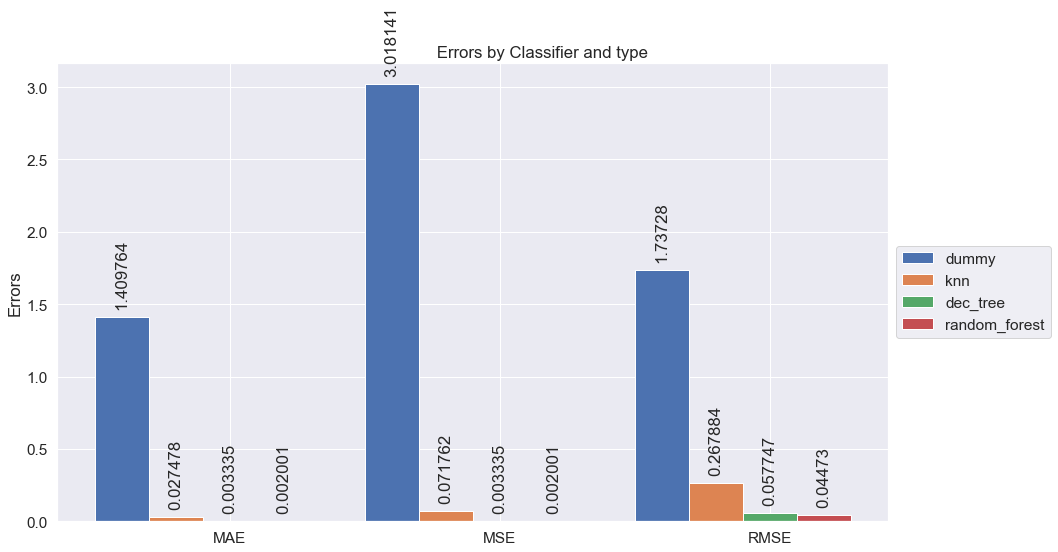

In [113]:
labels = ['MAE', 'MSE', 'RMSE']
dummy_l = [round(metrics.mean_absolute_error(y_test,y_dummy_predictions),6),round(metrics.mean_squared_error(y_test, y_dummy_predictions),6),round(np.sqrt(metrics.mean_squared_error(y_test, y_dummy_predictions)),6)]
knn_l = [round(metrics.mean_absolute_error(y_test,knn_tuned_pred),6),round(metrics.mean_squared_error(y_test, knn_tuned_pred),6),round(np.sqrt(metrics.mean_squared_error(y_test, knn_tuned_pred)),6)]
dec_tree_l= [round(metrics.mean_absolute_error(y_test,tuned_pred),6),round(metrics.mean_squared_error(y_test, tuned_pred),6),round(np.sqrt(metrics.mean_squared_error(y_test, tuned_pred)),6)]
rf_l =[round(metrics.mean_absolute_error(y_test,tuned_rf_pred),6),round(metrics.mean_squared_error(y_test, tuned_rf_pred),6),round(np.sqrt(metrics.mean_squared_error(y_test, tuned_rf_pred)),6)]
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=[15,8])
rects1 = ax.bar(x - 2*width, dummy_l, width, label='dummy')
rects2 = ax.bar(x - width, knn_l, width, label='knn')
rects3 = ax.bar(x , dec_tree_l, width, label='dec_tree')
rects4 = ax.bar(x + width, rf_l, width, label='random_forest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Errors')
ax.set_title('                              Errors by Classifier and type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 8),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',rotation=90)


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()

plt.show()

this is not the most beautful chart, but shows, that the different mean errors are going a lot down with each new classifier and that the random forest actually could outperform the other classifiers.

Therefore this is the Classifier we would go on for future deployment for the recommendation system, after the MVP.